Random Forest Regression Model ~ Jyosna

Reference:

https://ploomber.io/blog/nested-cv/

https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/

https://medium.com/@maziarizadi/pickle-your-model-in-python-2bbe7dba2bbb

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit,GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,root_mean_squared_error

In [8]:
x_train = pd.read_csv("C:\\Users\\jyosn\\Documents\\GitHub\\Predictive-Maintenance\\Datasets\\ForModelDev\\XTrain.csv")
y_train = pd.read_csv("C:\\Users\\jyosn\\Documents\\GitHub\\Predictive-Maintenance\\Datasets\\ForModelDev\\YTrain.csv")
engine = np.array(pd.read_csv("C:\\Users\\jyosn\\Documents\\GitHub\\Predictive-Maintenance\\Datasets\\ForModelDev\\Engine.csv"))

In [9]:
Y_train=np.asarray(y_train).ravel()
Engine=engine.ravel()

base model

In [10]:
gss_outer = GroupShuffleSplit(n_splits = 10, train_size = 0.7, random_state = 42) #n_splits refers to number of folds required
r2=[]
rmse=[]
for i, (train_index, val_index) in enumerate(gss_outer.split(x_train, Y_train, Engine)):
    xtrain = x_train.iloc[train_index, :] # Train Data from training set (70% split)
    ytrain = y_train.iloc[train_index, :]
    Y_train=np.asarray(ytrain).ravel()
    xval = x_train.iloc[val_index, :] # Validation Data from training set (30% split)
    yval = y_train.iloc[val_index, :]
    
    rf = RandomForestRegressor(n_estimators=100,random_state=42,min_samples_leaf=3)
    rf.fit(xtrain, Y_train)
    r2.append(r2_score(rf.predict(xval), yval))
    rmse.append(root_mean_squared_error(rf.predict(xval), yval))
print("r2: ",np.mean(r2))
print("rmse: ",np.mean(rmse))

r2:  0.521998024927043
rmse:  42.26665478996144


r2:  0.521998024927043

rmse:  42.26665478996144

hyperparameter tuning using nested cross validation

In [11]:
# configure the cross-validation procedure
from numpy import mean, std


# enumerate splits
outer_results = {"r2":[],"rmse":[]}
for i,(train_ix, test_ix) in enumerate(gss_outer.split(x_train, y_train, engine)):
    # split data
    X_train, X_val = x_train.iloc[train_ix, :], x_train.iloc[test_ix, :]
    Y_train, Y_val = y_train.iloc[train_ix], y_train.iloc[test_ix]
    Engine=engine[train_ix]
    Y_train=np.asarray(Y_train).ravel()
    Engine=Engine.ravel()
    # configure the cross-validation procedure
    gss_inner =  GroupShuffleSplit(n_splits = 3, train_size = 0.7, random_state = 42)
    # define the model
    rf = RandomForestRegressor(random_state=42)
    para={"n_estimators":[100,200,300],"max_depth":[6,8,10,12,14],"min_samples_leaf":[4,6,8,10],"criterion":["squared_error"],"ccp_alpha":[0,1,2] }

    # define search
    search = GridSearchCV(rf, param_grid=para, scoring=['r2','neg_root_mean_squared_error'], cv=gss_inner, refit='r2',n_jobs=-1)
    # execute search
    result = search.fit(X_train, Y_train,groups=Engine)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_val)
    # evaluate the model
    r2 = r2_score(Y_val, yhat)
    rmse=root_mean_squared_error(Y_val,yhat)
    # store the result
    outer_results["r2"].append(r2)
    outer_results["rmse"].append(rmse)
    # report progress
    print('>r2=%.3f, est=%.3f, cfg=%s' % (r2, result.best_score_, result.best_params_))
# summarize the estimated performance of the model
print('R2: %.3f (%.3f)' % (mean(outer_results["r2"]), std(outer_results["r2"])))
print('RMSE: %.3f (%.3f)' % (mean(outer_results["rmse"]), std(outer_results["rmse"])))



>r2=0.707, est=0.579, cfg={'ccp_alpha': 0, 'criterion': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 10, 'n_estimators': 300}
>r2=0.618, est=0.699, cfg={'ccp_alpha': 0, 'criterion': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 10, 'n_estimators': 200}
>r2=0.739, est=0.614, cfg={'ccp_alpha': 0, 'criterion': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 4, 'n_estimators': 100}
>r2=0.736, est=0.528, cfg={'ccp_alpha': 2, 'criterion': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 10, 'n_estimators': 200}
>r2=0.680, est=0.614, cfg={'ccp_alpha': 0, 'criterion': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 10, 'n_estimators': 300}
>r2=0.595, est=0.643, cfg={'ccp_alpha': 0, 'criterion': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 4, 'n_estimators': 300}
>r2=0.685, est=0.587, cfg={'ccp_alpha': 0, 'criterion': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 4, 'n_estimators': 200}
>r2=0.662, est=0.664, cfg={'ccp_alpha': 0, 'criterion': 'squared_

output

>r2=0.707, est=0.579, cfg={'ccp_alpha': 0, 'criterion': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 10, 'n_estimators': 300}

>r2=0.618, est=0.699, cfg={'ccp_alpha': 0, 'criterion': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 10, 'n_estimators': 200}

>r2=0.739, est=0.614, cfg={'ccp_alpha': 0, 'criterion': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 4, 'n_estimators': 100}

>r2=0.736, est=0.528, cfg={'ccp_alpha': 2, 'criterion': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 10, 'n_estimators': 200}

>r2=0.680, est=0.614, cfg={'ccp_alpha': 0, 'criterion': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 10, 'n_estimators': 300}

>r2=0.595, est=0.643, cfg={'ccp_alpha': 0, 'criterion': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 4, 'n_estimators': 300}

>r2=0.685, est=0.587, cfg={'ccp_alpha': 0, 'criterion': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 4, 'n_estimators': 200}

>r2=0.662, est=0.664, cfg={'ccp_alpha': 0, 'criterion': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 4, 'n_estimators': 100}

>r2=0.605, est=0.768, cfg={'ccp_alpha': 0, 'criterion': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 4, 'n_estimators': 200}

>r2=0.631, est=0.731, cfg={'ccp_alpha': 0, 'criterion': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 4, 'n_estimators': 300}

R2: 0.666 (0.050)

RMSE: 39.470 (3.912)

In [15]:
search = GridSearchCV(rf, param_grid=para, scoring=['r2','neg_root_mean_squared_error'], cv=gss_inner, refit='r2',n_jobs=3)
result = search.fit(X_train, Y_train,groups=Engine)
# get the best performing model fit on the whole training set
best_model = result.best_estimator_
# evaluate model on the hold out dataset
yhat = best_model.predict(X_val)
# evaluate the model
r2 = r2_score(Y_val, yhat)
rmse=root_mean_squared_error(Y_val,yhat)
# store the result

In [16]:
print(result.best_params_)
print("training accuracy: ")
print("r2: ", r2)
print("rmse: ",rmse)

{'ccp_alpha': 0, 'criterion': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 4, 'n_estimators': 300}
training accuracy: 
r2:  0.6305180806958393
rmse:  41.686543810103544


output

{'ccp_alpha': 0, 'criterion': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 4, 'n_estimators': 300}

training accuracy: 

r2:  0.6305180806958393

rmse:  41.686543810103544

In [17]:
import pickle
pickle.dump(best_model, open('random_forest_model.pkl','wb'))

In [20]:
import pickle 
model = pickle.load(open('random_forest_model.pkl','rb'))

In [21]:
xtest_data = pd.read_csv('C:\\Users\\jyosn\\Documents\\GitHub\\Predictive-Maintenance\\Datasets\\ForModelDev\\XTest.csv')
ytest_data  = pd.read_csv('C:\\Users\\jyosn\\Documents\\GitHub\\Predictive-Maintenance\\Datasets\\ForModelDev\\Ytest.csv')
engine_test_data = pd.read_csv('C:\\Users\\jyosn\\Documents\\GitHub\\Predictive-Maintenance\\Datasets\\ForModelDev\\Engine_test.csv')

In [22]:
ypred = model.predict(xtest_data)
print("Testing accuracy: ")
print('RMSE: ',np.sqrt(root_mean_squared_error(ytest_data, ypred)))
print('R2: ' ,r2_score(ytest_data, ypred))

Testing accuracy: 
RMSE:  6.681745197804529
R2:  0.42696442049807026


Testing accuracy: 

RMSE:  6.681745197804529

R2:  0.42696442049807026

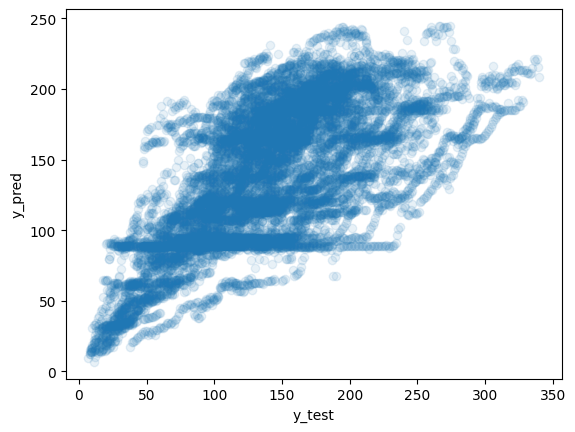

In [32]:
import matplotlib.pyplot as plt
fig=plt.figure()
plt.scatter(ytest_data,ypred,alpha=0.1,marker="o")
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

